In [1]:
!pip uninstall -y numpy ultralytics

!pip install ultralytics

!pip install "numpy<2.0" -U --force-reinstall

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 117.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import shutil
import configparser
import numpy as np

INPUT_TRAIN_PATH = '/kaggle/input/d/hannusiaknysh/mot-17/MOT17/train'
OUTPUT_DIR = '/kaggle/working/datasets/MOT17'

TRAIN_SUBSAMPLE = 10  
VAL_SUBSAMPLE = 1     
VAL_SEQ_NAME = 'MOT17-09-FRCNN' 

if not os.path.exists(os.path.join(INPUT_TRAIN_PATH, VAL_SEQ_NAME)):
    VAL_SEQ_NAME = 'MOT17-09-DPM'
    ALL_SEQS = [
        'MOT17-02-DPM', 'MOT17-04-DPM', 'MOT17-05-DPM', 
        'MOT17-09-DPM', 'MOT17-10-DPM', 'MOT17-11-DPM', 'MOT17-13-DPM'
    ]
else:
    ALL_SEQS = [
        'MOT17-02-FRCNN', 'MOT17-04-FRCNN', 'MOT17-05-FRCNN', 
        'MOT17-09-FRCNN', 'MOT17-10-FRCNN', 'MOT17-11-FRCNN', 'MOT17-13-FRCNN'
    ]

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR) 

cache_list = [
    '/kaggle/working/datasets/MOT17/labels/train.cache',
    '/kaggle/working/datasets/MOT17/labels/val.cache'
]
for c in cache_list:
    if os.path.exists(c): os.remove(c)

for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, f'images/{split}'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, f'labels/{split}'), exist_ok=True)

def convert_to_yolo_bbox_clipped(img_w, img_h, box):
    x1, y1, w, h = box
    x2, y2 = x1 + w, y1 + h
    
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(img_w, x2); y2 = min(img_h, y2)
    
    w, h = x2 - x1, y2 - y1
    if w <= 1 or h <= 1: return None
        
    return [((x1 + w / 2) / img_w), ((y1 + h / 2) / img_h), (w / img_w), (h / img_h)]

for seq in ALL_SEQS:
    is_validation = (seq == VAL_SEQ_NAME)
    split_name = 'val' if is_validation else 'train'
    subsample = VAL_SUBSAMPLE if is_validation else TRAIN_SUBSAMPLE
    
    seq_path = os.path.join(INPUT_TRAIN_PATH, seq)
    
    try:
        config = configparser.ConfigParser()
        config.read(os.path.join(seq_path, 'seqinfo.ini'))
        img_w = int(config['Sequence']['imWidth'])
        img_h = int(config['Sequence']['imHeight'])
    except Exception as e:
        print(f"❌ Error reading config {seq}: {e}")
        continue

    gt_data = {}
    with open(os.path.join(seq_path, 'gt/gt.txt'), 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[7]) == 1 and float(parts[8]) >= 0.25:
                frame = int(parts[0])
                if frame % subsample == 0:
                    bbox = [float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5])]
                    yolo_box = convert_to_yolo_bbox_clipped(img_w, img_h, bbox)
                    if yolo_box:
                        row = f"0 {' '.join(f'{x:.6f}' for x in yolo_box)}\n"
                        if frame not in gt_data: gt_data[frame] = []
                        gt_data[frame].append(row)

    img_dir = os.path.join(seq_path, 'img1')
    images = sorted(os.listdir(img_dir))
    count = 0
    for img_file in images:
        frame_id = int(img_file.split('.')[0])
        if frame_id % subsample == 0:
            new_name = f"{seq}_{img_file}"
            shutil.copy(os.path.join(img_dir, img_file), os.path.join(OUTPUT_DIR, f'images/{split_name}', new_name))
            
            lbl_name = new_name.replace('.jpg', '.txt')
            with open(os.path.join(OUTPUT_DIR, f'labels/{split_name}', lbl_name), 'w') as out_f:
                if frame_id in gt_data: out_f.writelines(gt_data[frame_id])
            count += 1

In [3]:
import yaml

data_config = {
    'path': '/kaggle/working/datasets/MOT17',  
    'train': 'images/train',                   
    'val': 'images/val',                       
    'names': {
        0: 'pedestrian'                        
    }
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data_config, f)

In [4]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt') 

results = model.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    project='mot_project',
    name='yolo_v8s_baseline',
    amp=False,
    workers=2,
    close_mosaic=10,
    save=True,
    save_period=10,
    plots=True,
    deterministic=True,
    seed=42
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        525       3745      0.882      0.848      0.931       0.65
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/mot_project/yolo_v8s_baseline


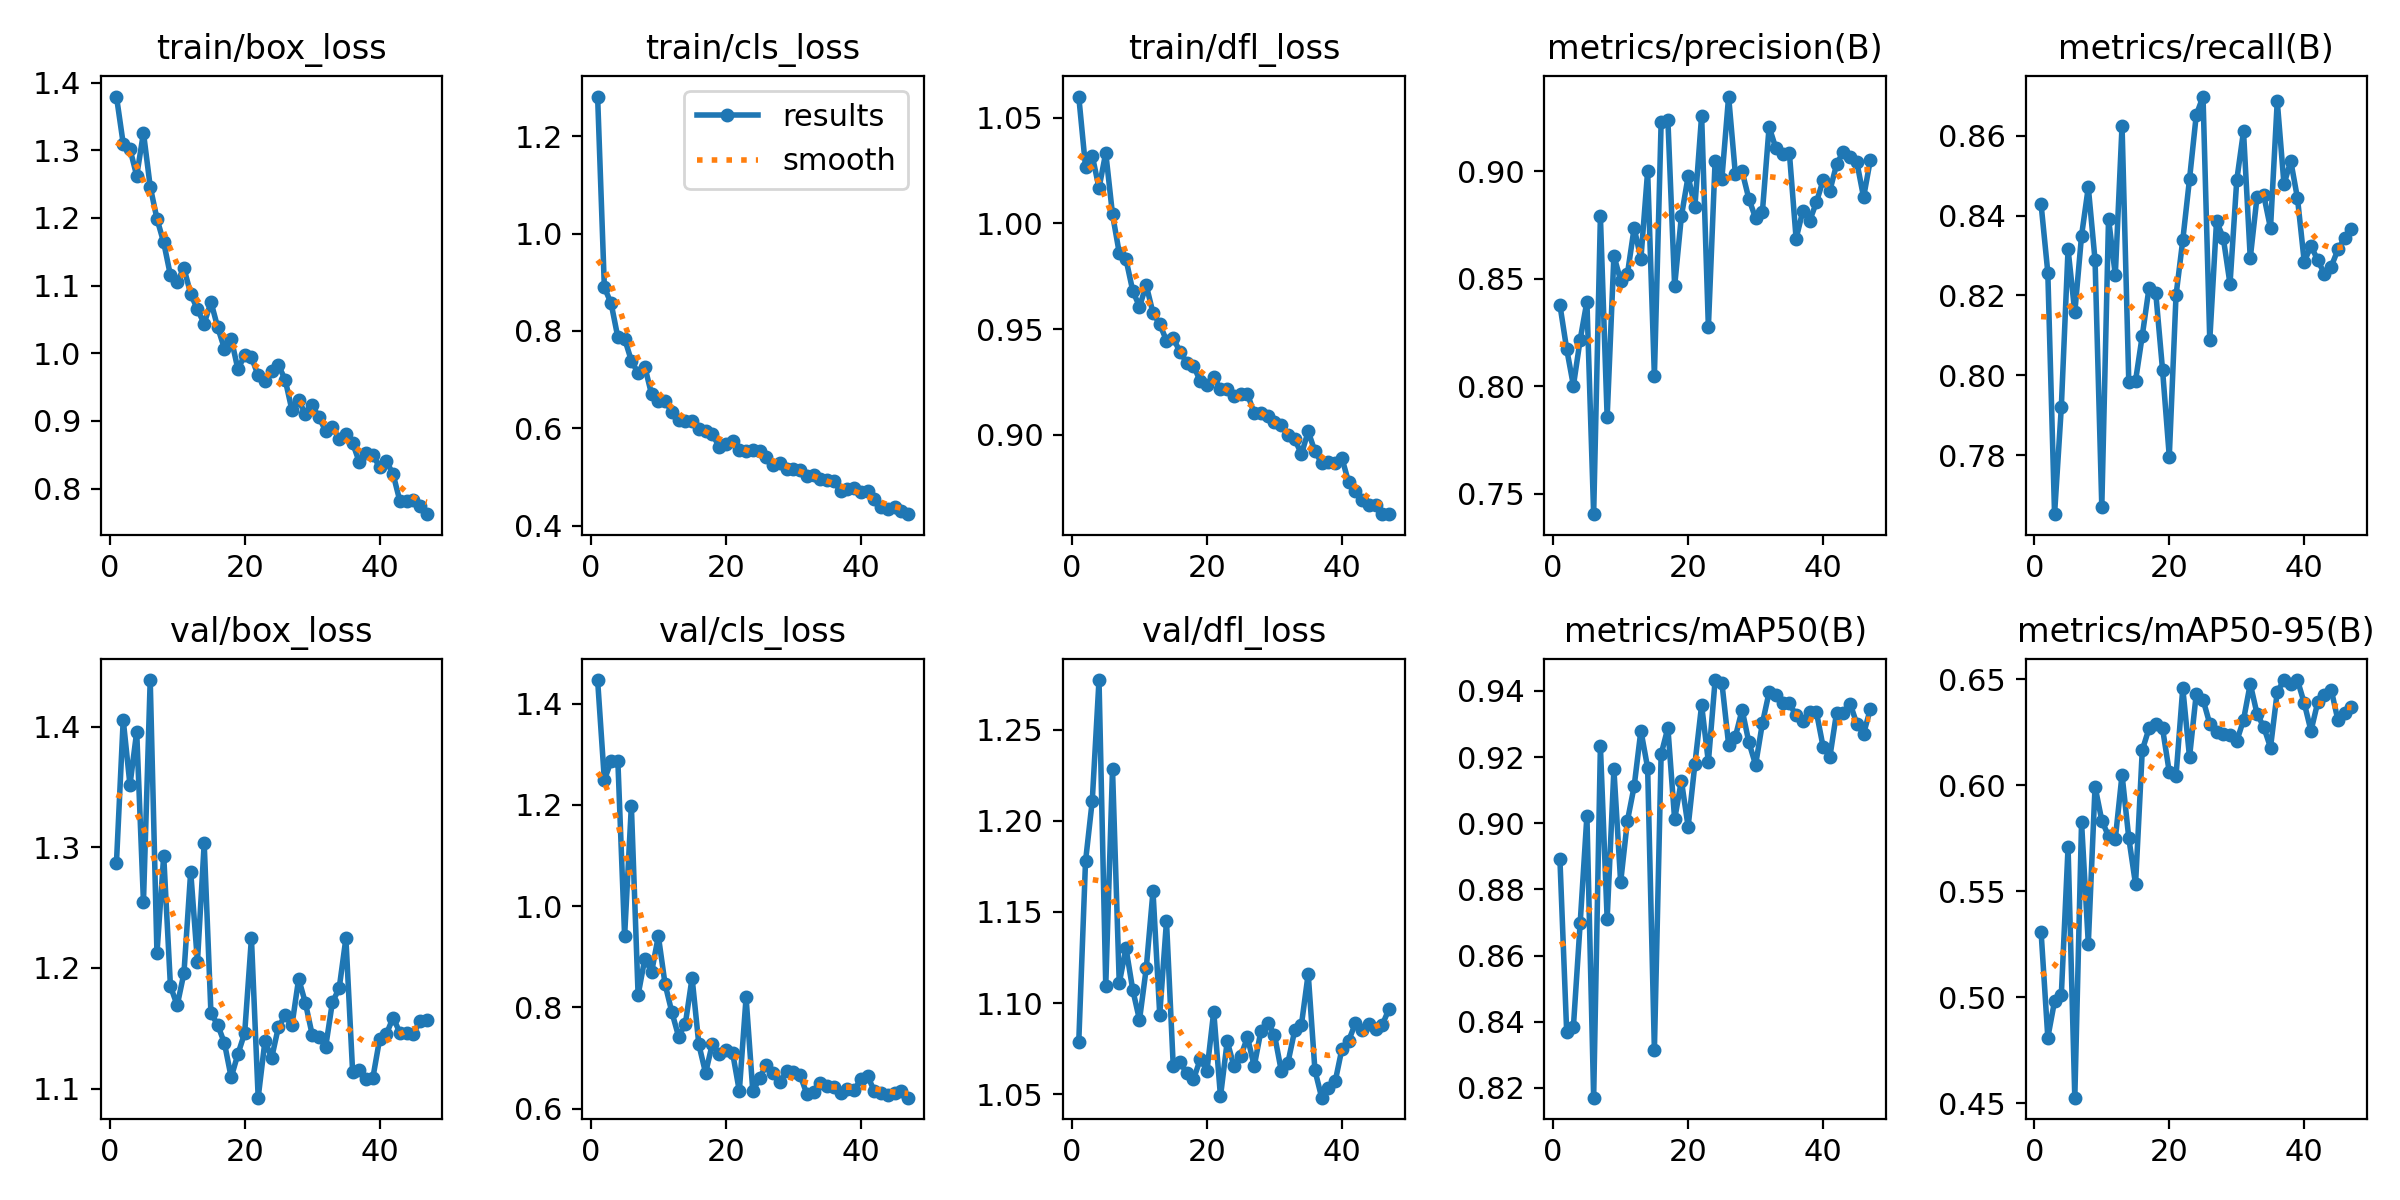

In [5]:
from IPython.display import Image, display
import os

run_path = '/kaggle/working/mot_project/yolo_v8s_baseline'

display(Image(filename=os.path.join(run_path, 'results.png')))